In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from colicoords import load, CellPlot
from colicoords.minimizers import *
import time

This example notebook will go over the different input data classes that can be used as well as their objective functions that are minimized in order to optimize the coordinate system for this given data class. 

The fitting of the coordinate system to the data is internally handled by `symfit` which allows for the custom models to be fitted by `scipy.minimize` through a pythonic and easy to use API. All `symfit` minimizers are available through importing from `colicoords.minimizers`.

### Contents
1. [Binary Images](#binary)
2. [Brightfield Images](#brightfield)
3. [STORM data](#storm)
4. [Multiprocessing](#multiprocessing)



## Optimization by binary images<a name="binary"></a>

Optimization by the binary image is the default optimization process in `ColiCoords`. The binary optimization process is the easiest to calculate and therefore the fastest, but the accuracy of the method is limited. We will load the set of cells from example two which were saved before optimizing them. Therefore the parameters of their coordinate system are the initial guesses.

In [2]:
cells = load('data/04_cells_pre_optimization.hdf5')

In [3]:
cell = cells[0]
cp = CellPlot(cell)

The optimization process is for a data classes based on calculating some values or image based on the current coordinate system and then comparing this to the measured data by calculating the chi-squared. More information on the implementation of this process can be found in the optimization section of the docs. 

The following figure demonstrates how the optimization process works:

<IPython.core.display.Javascript object>


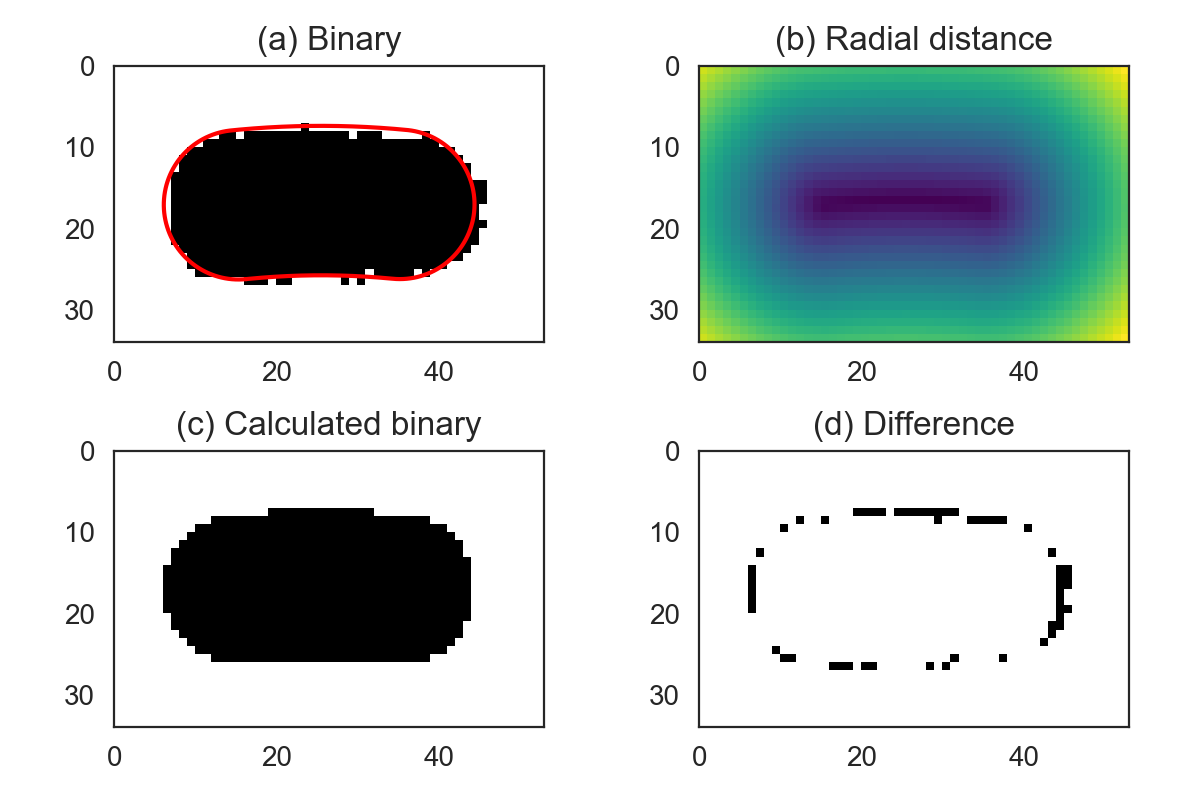

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(6,4))
cp.imshow('binary', ax=axes[0, 0])
cp.plot_outline(ax=axes[0, 0])
axes[0, 0].set_title('(a) Binary')

cp.imshow(cell.coords.rc, ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('(b) Radial distance')

cp.imshow(cell.coords.rc < cell.coords.r, ax=axes[1, 0], cmap='gray_r')
axes[1, 0].set_title('(c) Calculated binary')


difference = ((cell.coords.rc < cell.coords.r) - cell.data.binary_img)**2
cp.imshow(difference)
axes[1, 1].set_title('(d) Difference')

plt.tight_layout()

In figure (a) the measured binary is shown together with the outline of the inital guess coordinate system. To now optimize the coordinate system based on the binary image, a new binary image is calculated by thresholding the radial distance map (b) with the current radius of the cell resulting in a new binary image (c). The difference between the calculated and binary is shown in panel (d). The sum of the difference image is the chi-squared and is minimized by `symfit`, and in the process the parameters are found such that the coordinate system best describes the binary image. 

In [5]:
float(np.sum(difference))

57.0

By summing the difference image we find that the current chi-squared value is 57. In case of binary images, this means that there are 57 pixels that do not match. In the cell below we make a copy of the cell object and then optimize the new cell object to reduce this mismatch.

In [6]:
cell_opt = cell.copy()
res = cell_opt.optimize()
cp_opt = CellPlot(cell_opt)
res.objective_value

array(30.)

<IPython.core.display.Javascript object>


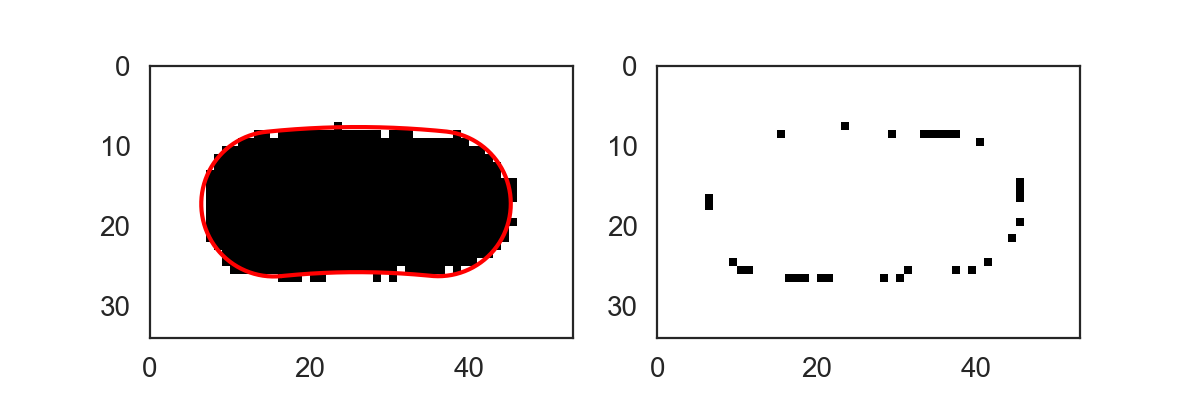

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6,2))
cp_opt.imshow('binary', ax=axes[0])
cp_opt.plot_outline(ax=axes[0])

difference = ((cell_opt.coords.rc < cell_opt.coords.r) - cell_opt.data.binary_img)**2
cp_opt.imshow(difference, ax=axes[1])

The coordinate system describes the cell now much better. The default minimizer used in the fitting process is the [`Powell`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html) minimizer. Although this minimizer is fast is does not always find the global minimum. To further improve the result, global minimizers supported by `symfit` can be used. 

The `DifferentialEvolution` algoritm is able to search large parameter spaces to find the global minimum of the problem. The implementation used is stochastic in nature and is therefore not guaranteed to return the same minimum on every run. 

In [8]:
cell_opt = cell.copy()
t0 = time.time()
res = cell_opt.optimize(minimizer=DifferentialEvolution)
t1 = time.time()

print(f"The cell was optimized in {int(t1-t0)} seconds")
res.objective_value

The cell was optimized in 103 seconds


23.0

<IPython.core.display.Javascript object>


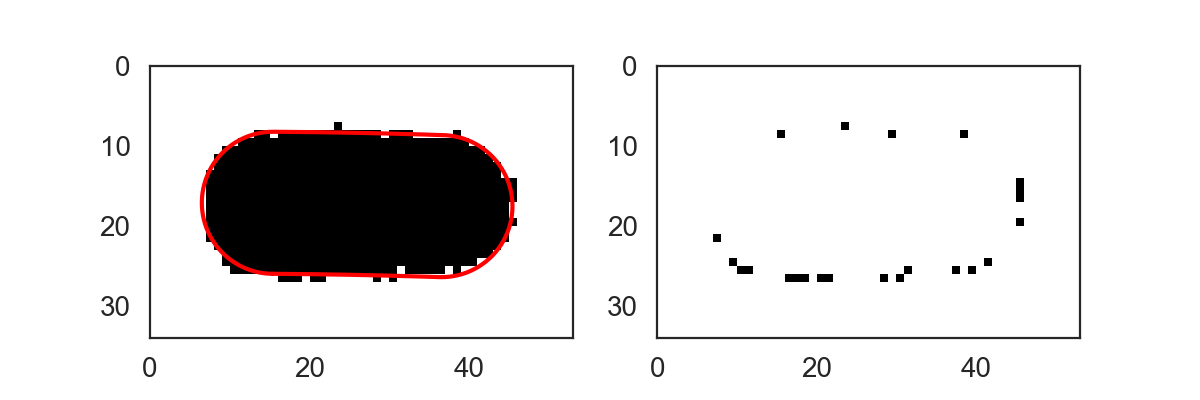

In [9]:
cp_opt = CellPlot(cell_opt)
fig, axes = plt.subplots(1, 2, figsize=(6,2))
cp_opt.imshow('binary', ax=axes[0])
cp_opt.plot_outline(ax=axes[0])

difference = ((cell_opt.coords.rc < cell_opt.coords.r) - cell_opt.data.binary_img)**2
cp_opt.imshow(difference, ax=axes[1])

## Optimization by brightfield images<a name="brightfield"></a>

Similar to the optimization process by binary images the coordinate system can be optimized with brightfield images as input. The basic principle is the same - a new image is calculated based on the current coordinate system and is compared to the measured brightfield image. 

The method is very robust against noise or local variations in signal. The only requirement for the method to work is that the image has to be isotropic. This means that the same approach can be applied to any isotropic fluorescence image. In the figure below the steps are illustrated.

<IPython.core.display.Javascript object>


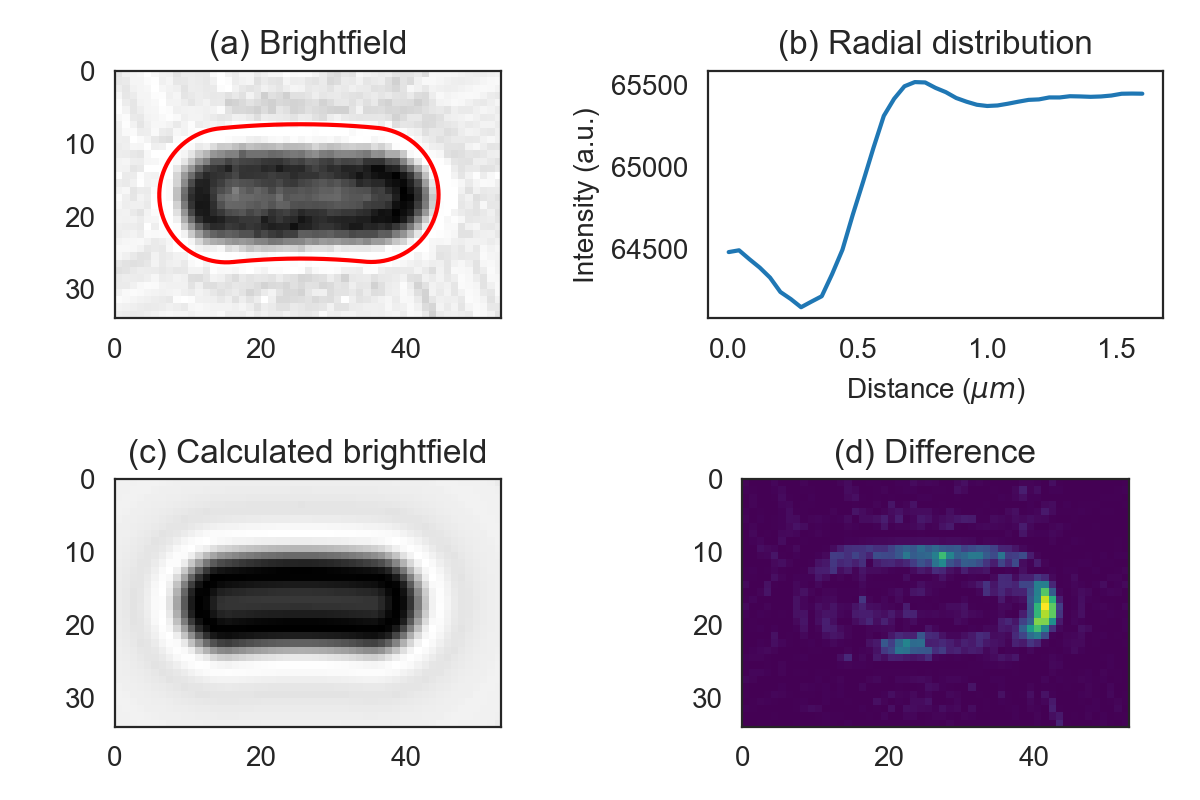

25788605.54275663

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(6,4))
cp.imshow('brightfield', ax=axes[0, 0])
cp.plot_outline(ax=axes[0, 0])
axes[0, 0].set_title('(a) Brightfield')

cp.plot_r_dist(data_name='brightfield', ax=axes[0, 1])
axes[0, 1].set_title('(b) Radial distribution')

img = cell.reconstruct_image('brightfield')
cp.imshow(img, ax=axes[1, 0], cmap='gray')
axes[1, 0].set_title('(c) Calculated brightfield')


difference = (img - cell.data.data_dict['brightfield'])**2
cp.imshow(difference, cmap='viridis')
axes[1, 1].set_title('(d) Difference')
plt.tight_layout()

float(np.sum(difference))

In panel (a) the measured brightfield image is shown together with the outline of the initial guess coordinate system. First, the radial distribution curve is calculated for the whole image (b). This curve, together with the radial distance image, is used to calculate a new brightfield image. Inaccuracies in the radial distribution and the radial distance image as well as anisotropic fluctuations will lead to differences between both images (d). From the difference image a clear outline of the cell can be seen, which means there are systematic errors in the current coordinate system parameters.

We can optimize the coordinate system by giving the data element's name as argument to `optimize`. The objective function is chosen automatically based on the data class used.

In [12]:
cell_opt = cell.copy()
res = cell_opt.optimize('brightfield')
res.objective_value

array(10016887.12381686)

<IPython.core.display.Javascript object>


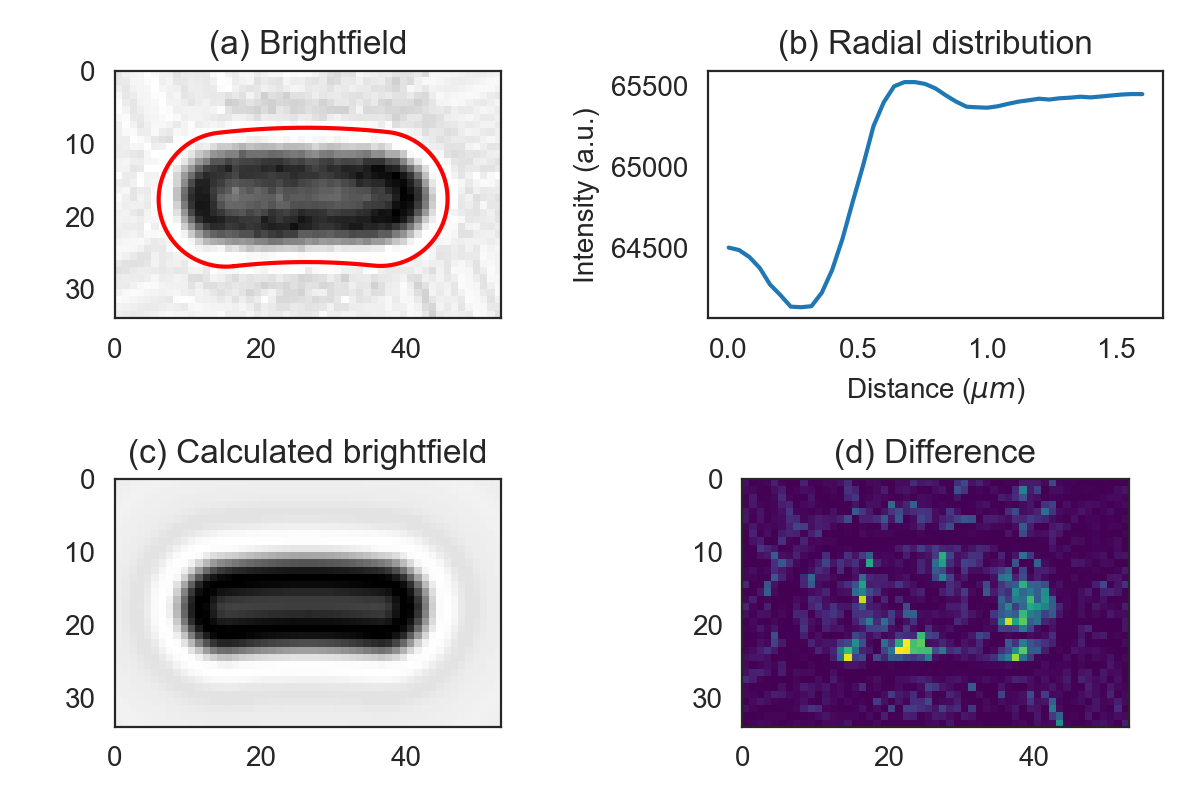

9780823.64358179

In [15]:
cp_opt = CellPlot(cell_opt)
fig, axes = plt.subplots(2, 2, figsize=(6,4))

cp_opt.imshow('brightfield', ax=axes[0, 0])
cp_opt.plot_outline(ax=axes[0, 0])
axes[0, 0].set_title('(a) Brightfield')

cp_opt.plot_r_dist(data_name='brightfield', ax=axes[0, 1])
axes[0, 1].set_title('(b) Radial distribution')

img = cell_opt.reconstruct_image('brightfield')
cp_opt.imshow(img, ax=axes[1, 0], cmap='gray')
axes[1, 0].set_title('(c) Calculated brightfield')

difference = (img - cell_opt.data.data_dict['brightfield'])**2
cp_opt.imshow(difference, cmap='viridis')
axes[1, 1].set_title('(d) Difference')
plt.tight_layout()

float(np.sum(difference))

The slight difference between the objective value and the sum of the differences as calculated in the cell above is because `ColiCoords` uses different parameters interally to calculate the radial distribution which allows for faster computation. 

When looking at the difference image in panel (d) it is clear that the optimization has improved the match between the two images. The outline of the cell is dark which means the match between calculated and is good. This behaviour is in this case anamalous and is caused by the lack noise which is a result from the camera being saturated on the outline of the cell. Since the image still forfills the requirement of being isotropic, the optimization still gives the desired result.

Again, using a global optimizer, the result can be further refined. Although being computationally expensive, `DifferentialEvolution` optimization on the brightfield image generally gives the best results.

In [16]:
cell_opt = cell.copy()
t0 = time.time()
res = cell_opt.optimize('brightfield', minimizer=DifferentialEvolution)
t1 = time.time()

print(f"The cell was optimized in {int(t1-t0)} seconds")
res.objective_value

The cell was optimized in 150 seconds


8191322.890772412

<IPython.core.display.Javascript object>


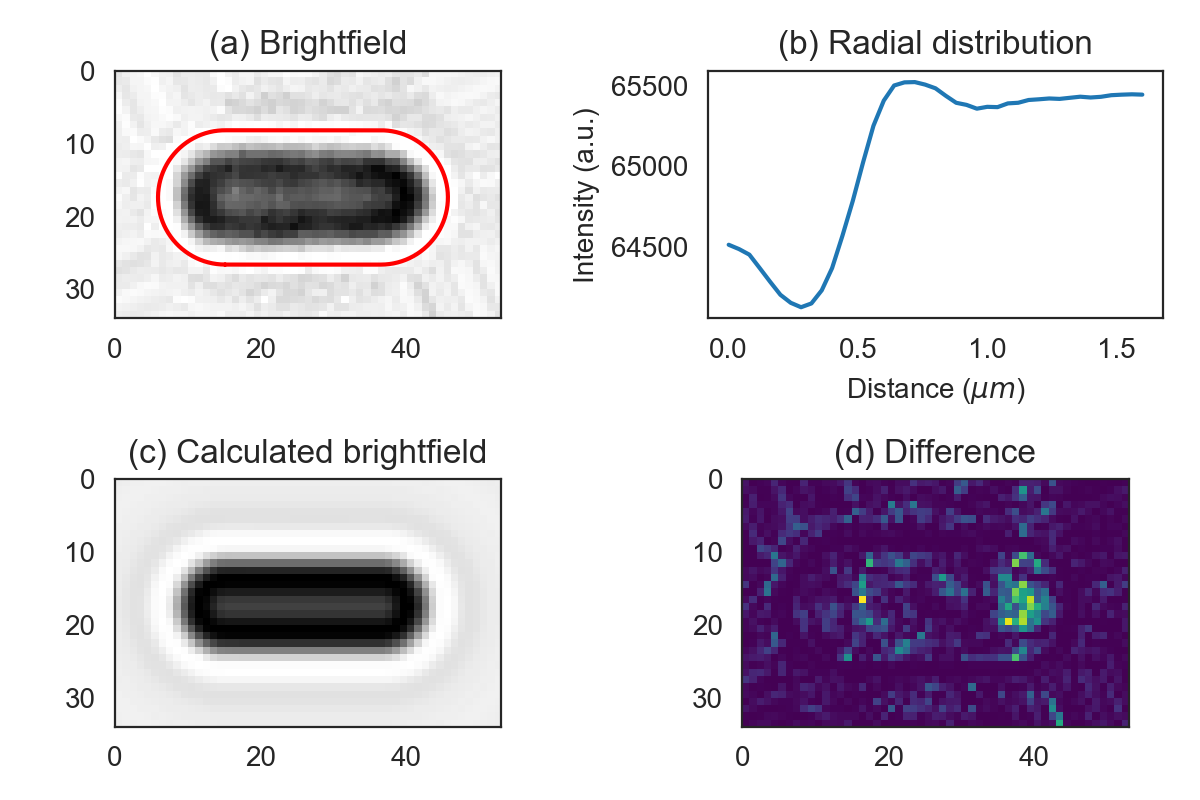

8017090.14358292

In [92]:
cp_opt = CellPlot(cell_opt)
fig, axes = plt.subplots(2, 2, figsize=(6,4))

cp_opt.imshow('brightfield', ax=axes[0, 0])
cp_opt.plot_outline(ax=axes[0, 0])
axes[0, 0].set_title('(a) Brightfield')

cp_opt.plot_r_dist(data_name='brightfield', ax=axes[0, 1])
axes[0, 1].set_title('(b) Radial distribution')

img = cell_opt.reconstruct_cell('brightfield')
cp_opt.imshow(img, ax=axes[1, 0], cmap='gray')
axes[1, 0].set_title('(c) Calculated brightfield')

difference = (img - cell_opt.data.data_dict['brightfield'])**2
cp_opt.imshow(difference, cmap='viridis')
axes[1, 1].set_title('(d) Difference')
plt.tight_layout()

float(np.sum(difference))

## Optimization by STORM super-resolution data<a name="storm"></a>

`ColiCoords` can also optimize the coordinate system of the cell based on STORM/PAINT type super-resolution imaging of the cell membrane. To demonstrate the process, a set of synthetic cell are loaded where each has a data element with STORM localizations

In [17]:
cells = load('data/03_synthetic_cells.hdf5')
cell = cells[0]

<IPython.core.display.Javascript object>


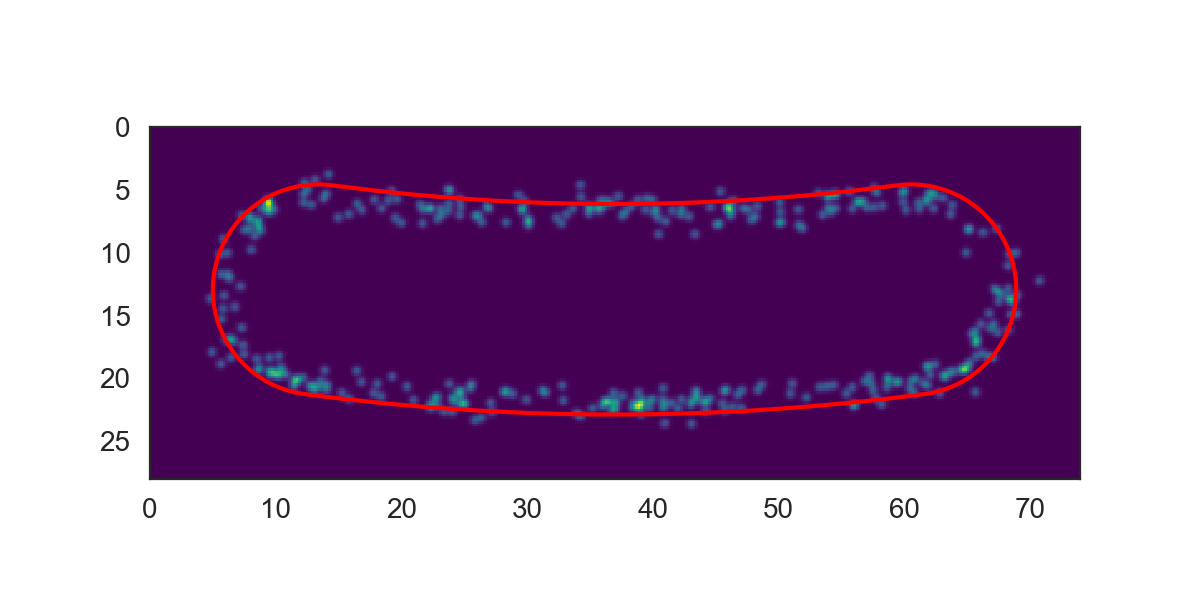

In [18]:
cp = CellPlot(cell)

plt.figure(figsize=(6, 3))
cp.plot_storm(method='gauss')
cp.plot_outline()

As can be seen in the image above, the coordinate system shape perfectly matches the shape of the cell. This is because the cell was created synthetically and the coordinate system is used to generate the STORM coordinates. The current oultine is shown in red and is slightly larger than the mean radial distance of the STORM localizations - this is how the dataset was generated. 

The optimization by STORM localizations on the membrane works by calculating the radial distance of each localization and comparing it to the overall radius of the cell. This difference gives the chi-squared and if minimized the coordinate system best describes the cell outline as measured by the super-resolution data.

Since in this example the coordinate system was generated and already is the best fit we will first pertub it and then perform the optimization process.

<IPython.core.display.Javascript object>


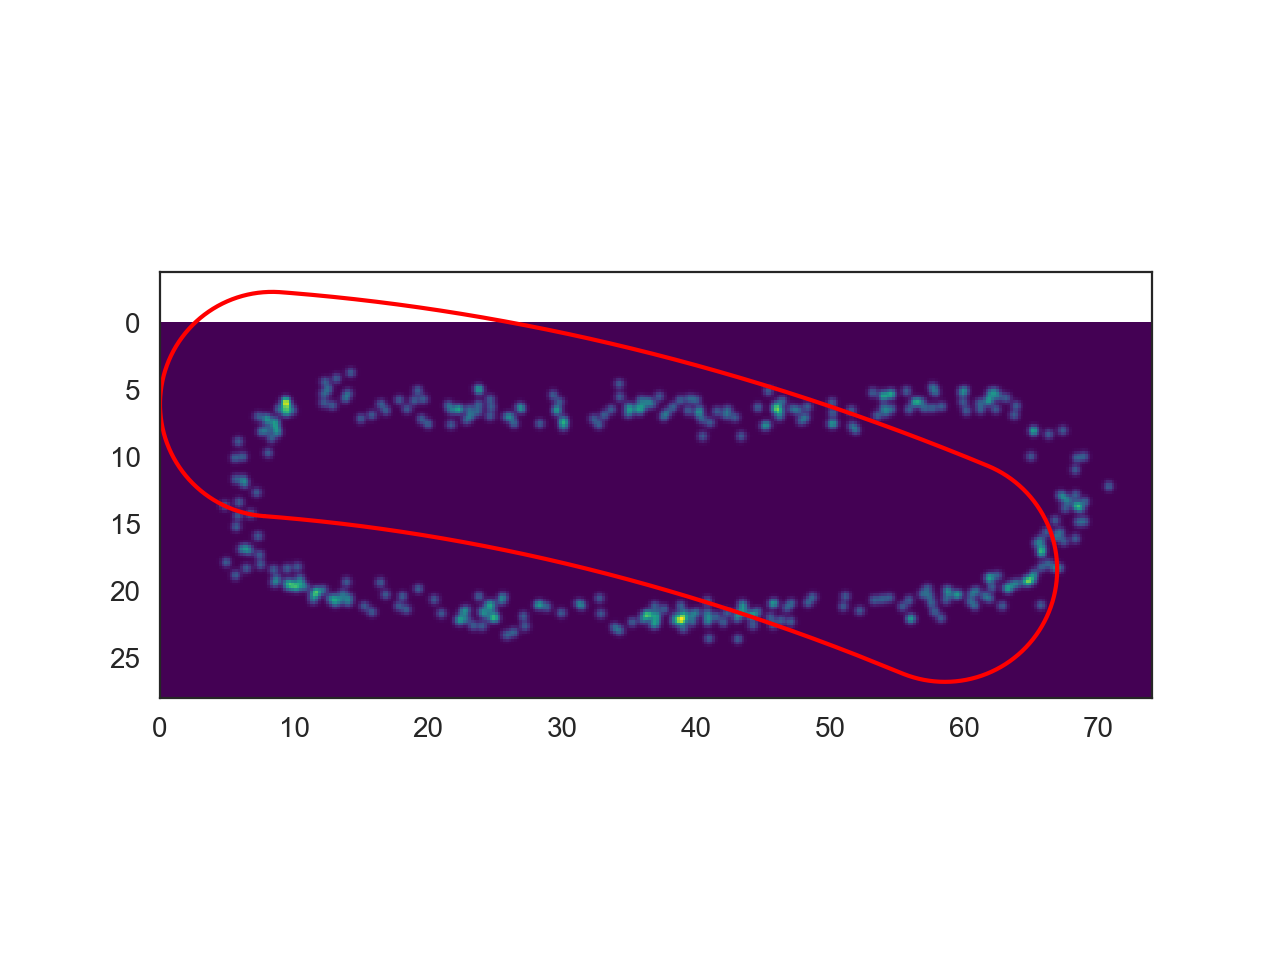

In [19]:
c_opt = cell.copy()
c_opt.coords.xl -= 5
c_opt.coords.xr -= 2
c_opt.coords.a0 -= 5
c_opt.coords.a1 *= 0.1
c_opt.coords.a2 *= -1.2

cp_opt = CellPlot(c_opt)
plt.figure()
cp_opt.plot_storm(method='gauss')
cp_opt.plot_outline()

The radial distances for every STORM localization can be calculated as follows, and then the squared difference with the cell's radius gives the chi-squared:

In [20]:
r_values = c_opt.coords.calc_rc(c_opt.data.data_dict['storm']['x'], c_opt.data.data_dict['storm']['y'])
float(np.sum((r_values - c_opt.radius)**2))

7304.012362989295

In [21]:
res = c_opt.optimize('storm')

In [22]:
print(res.objective_value)

214.05394965439962


<IPython.core.display.Javascript object>


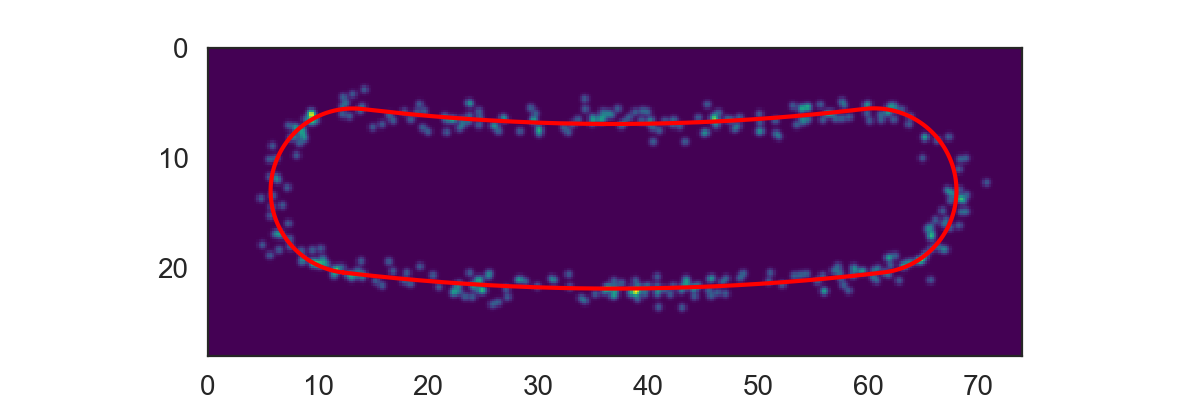

In [23]:
plt.figure(figsize=(6, 2))
cp_opt.plot_storm(method='gauss')
cp_opt.plot_outline()

## Multiprocessing

`ColiCoords` supports high-performance computing to speed up the optimization process of many cells.

In [24]:
res_list = cells.optimize_mp()

The function `optimize_mp` is identical to `optimize` except from the multiprocessing ability. An extra keyword that can be provided to `optimize_mp` is 'processes', which defaults to the number of cores present. When executing `optimize_mp` on Windows outside of Jupyter notebooks, the function call needs to be protected by `if __name__ == '__main__':` as ususal.